# Microsof Movies

## Data Understanding

the data we are going to use for our analysis is contained in:

1. `im.db.zip`: which is a database from which 
    `movie_basics` and `movie_ratings` tables are extracted
2. `bom.movie_gross.csv.gz`: which is a CSV file

## Business Understanding

The business questions we intend to answer are:

1.	Which genre(s) are rated the best?
2.	What are the most popular movie genre(s)?
3.	What is the relationship between the rating and runtime of a movie?
4.	Who are the pioneers in the industry?
5.  whether there is any relationship between domestic and international marketing of a movie

# Extracting data files

### Extracting Database Files

In [1]:
#importing relevant modules
import sqlite3
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
#creating connection
conn = sqlite3.connect("sqlite/im.db")

In [3]:
#Enabling Cursor so that we can querry the database
cur = conn.cursor()

In [4]:
#identifying tables
cur.execute(""" SELECT name FROM sqlite_master WHERE type = 'table';""")
#fetching all tables contained in the database
database_tables = cur.fetchall()
#displaying tables
database_tables

[('movie_basics',),
 ('directors',),
 ('known_for',),
 ('movie_akas',),
 ('movie_ratings',),
 ('persons',),
 ('principals',),
 ('writers',)]

In [5]:
#selecting movie_basics table from the database
movie_basics = pd.read_sql("""
SELECT * 
FROM 
movie_basics;""", conn)

In [6]:
#previewing contents of movie_basics
movie_basics.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"


In [7]:
#getting movie_ratings from the database
movie_ratings = pd.read_sql("""
SELECT *
FROM movie_ratings;""", conn)

In [8]:
#previewing contents of  movie_ratings
movie_ratings.head()

,movie_id,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20
3,tt1043726,4.2,50352
4,tt1060240,6.5,21


## Performing data cleaning to answer questions

#### Joining database files for analysis

In [37]:
#joining tables
joined_tables = movie_basics.join(movie_ratings, rsuffix = 'movie_id', how='inner')
#previewing contents for confirmation
joined_tables.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,movie_idmovie_id,averagerating,numvotes
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",tt10356526,8.3,31
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",tt10384606,8.9,559
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,tt1042974,6.4,20
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama",tt1043726,4.2,50352
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy",tt1060240,6.5,21


#### identifying and handling missing values

In [10]:
joined_tables.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73856 entries, 0 to 73855
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   movie_id          73856 non-null  object 
 1   primary_title     73856 non-null  object 
 2   original_title    73853 non-null  object 
 3   start_year        73856 non-null  int64  
 4   runtime_minutes   61529 non-null  float64
 5   genres            72066 non-null  object 
 6   movie_idmovie_id  73856 non-null  object 
 7   averagerating     73856 non-null  float64
 8   numvotes          73856 non-null  int64  
dtypes: float64(2), int64(2), object(5)
memory usage: 5.6+ MB


runtime_minutes and genres columns have missing values. Except runtime_minutes, averagerating and numvotes, which are contain numeric data, the rest of the columsns contain categorical data 

#### Dropping missing values

In [11]:
joined_tables.dropna(inplace = True)

#### confirming whether there are any missing values remaining

In [12]:
joined_tables.isna().sum()

movie_id            0
primary_title       0
original_title      0
start_year          0
runtime_minutes     0
genres              0
movie_idmovie_id    0
averagerating       0
numvotes            0
dtype: int64

## determing which genre/type of movie that are doing the best

Note: it is assumed that the higher the rating, the better in demand the movie is

First, let's convert start_year, runtime_minutes  and numvotes colums so that they are not included in the calculations 

In [13]:
joined_tables['start_year'] =  joined_tables['start_year'].astype('str')
joined_tables['runtime_minutes'] =  joined_tables['runtime_minutes'].astype('str')
joined_tables['numvotes'] =  joined_tables['numvotes'].astype('str')

Confirming above columns are converted to string

In [14]:
joined_tables.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60630 entries, 0 to 73854
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   movie_id          60630 non-null  object 
 1   primary_title     60630 non-null  object 
 2   original_title    60630 non-null  object 
 3   start_year        60630 non-null  object 
 4   runtime_minutes   60630 non-null  object 
 5   genres            60630 non-null  object 
 6   movie_idmovie_id  60630 non-null  object 
 7   averagerating     60630 non-null  float64
 8   numvotes          60630 non-null  object 
dtypes: float64(1), object(8)
memory usage: 4.6+ MB


Grouping DataFrame by genres and calculating Rating

In [15]:
genre_ranking = joined_tables.groupby(['genres'])['averagerating'].sum().sort_values(ascending = False)

Obtaining the first 6 genres with the highest rating values

In [16]:
genre_ranking.head(6)

genres
Documentary              58918.4
Drama                    51806.6
Comedy                   21439.3
Comedy,Drama             11800.3
Horror                    9901.4
Biography,Documentary     7953.4
Name: averagerating, dtype: float64

below we plot the first 6 movies with the highest rating

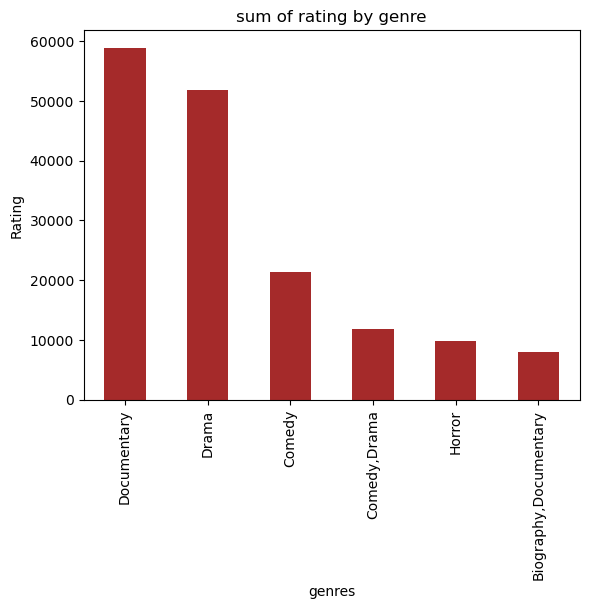

In [17]:
genre_ranking.head(6).plot.bar(color = 'brown')
plt.ylabel("Rating")
plt.title("sum of rating by genre")
plt.show();

## determining the most popular genre(s)

To determine the best voted genre(s) or combination of genres, we group the dataset by genre and then calculate the sum of  `'numvotes'` for each genre

First, le's Covert  `'numvotes'`  back to original its original datatype

In [18]:
joined_tables['numvotes'] =  joined_tables['numvotes'].astype('int64')

confirming `'numvotes'` is converted to its original datatype

In [19]:
joined_tables.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60630 entries, 0 to 73854
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   movie_id          60630 non-null  object 
 1   primary_title     60630 non-null  object 
 2   original_title    60630 non-null  object 
 3   start_year        60630 non-null  object 
 4   runtime_minutes   60630 non-null  object 
 5   genres            60630 non-null  object 
 6   movie_idmovie_id  60630 non-null  object 
 7   averagerating     60630 non-null  float64
 8   numvotes          60630 non-null  int64  
dtypes: float64(1), int64(1), object(7)
memory usage: 4.6+ MB


Now we group the dataset by genre and then calculate the sum of  `'numvotes'` for each genre in a descending order

Note: only the first 20 genre(s) or combination of genres with the highest `'numvotes'` are displayed

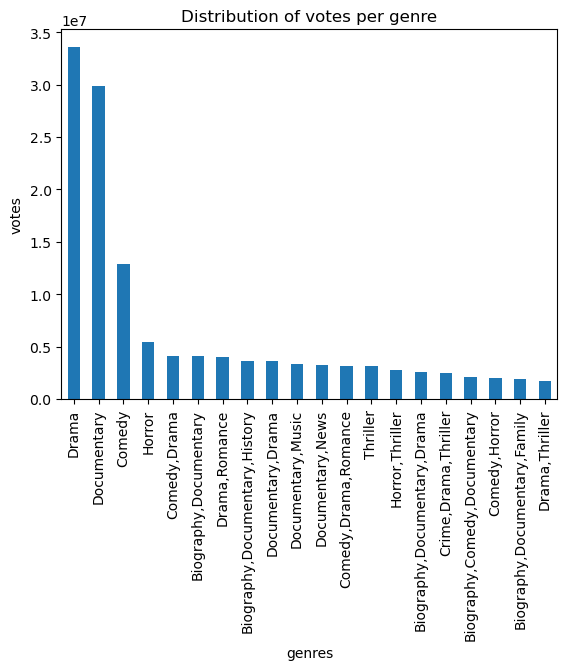

In [20]:
joined_tables.groupby(['genres'])['numvotes'].sum().sort_values(ascending = False).head(20).plot.bar(ylabel = 'votes', title = "Distribution of votes per genre");

## What is the relationship between the rating and runtime of a movie genre?

In [158]:
joined_tables['runtime_minutes'] =  joined_tables['runtime_minutes'].astype('float64')

C:\Users\SMICER\AppData\Local\Temp\ipykernel_10512\1489255061.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  joined_tables.groupby(['genres'])['runtime_minutes', 'averagerating'].sum().head(20).plot(kind = 'barh', figsize = (15,8));


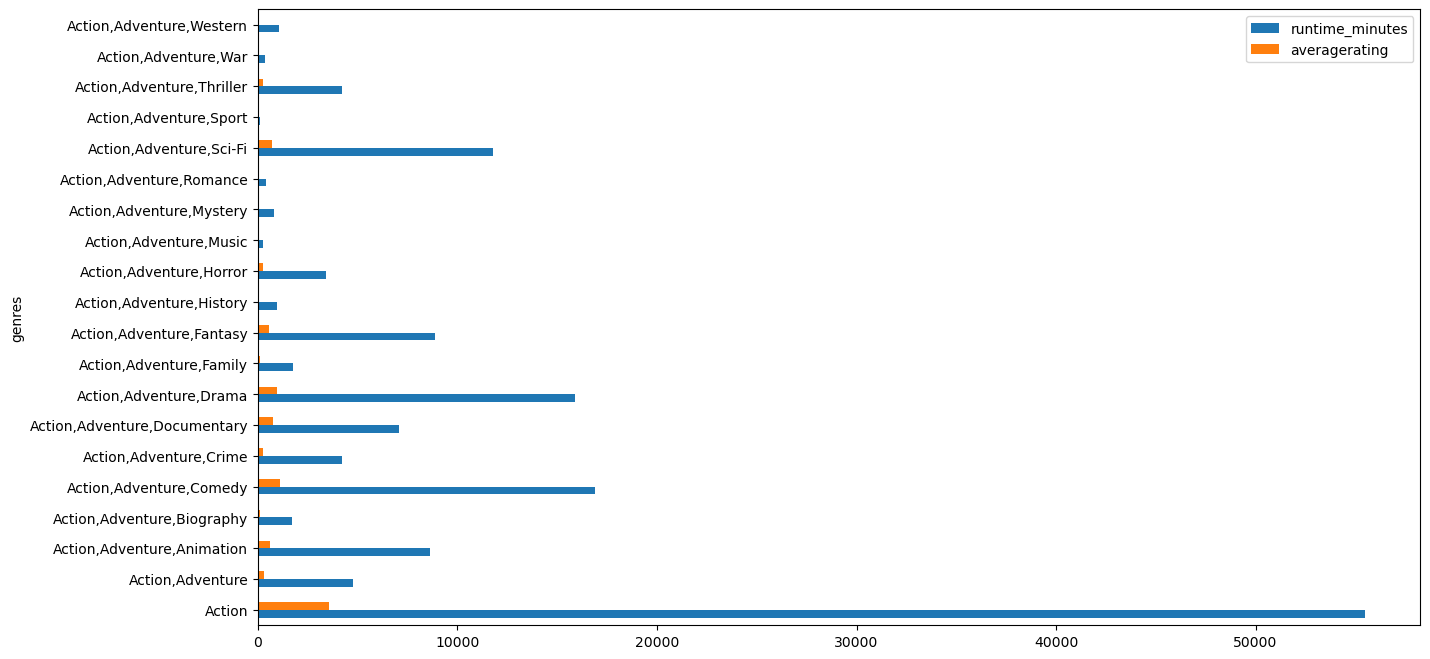

In [36]:
joined_tables.groupby(['genres'])['runtime_minutes', 'averagerating'].sum().head(20).plot(kind = 'barh', figsize = (15,8));

##  Which are the best performing studios?

To answer this question, we are going to use `bom.movie_gross.csv.gz` which is a CSV file

In [83]:
#reading the file
movie_gross = pd.read_csv("bom.movie_gross.csv.gz")
movie_gross

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010
...,...,...,...,...,...
3382,The Quake,Magn.,6200.0,NaN,2018
3383,Edward II (2018 re-release),FM,4800.0,NaN,2018
3384,El Pacto,Sony,2500.0,NaN,2018
3385,The Swan,Synergetic,2400.0,NaN,2018


inspecting the file for missing values and incorrect data types

In [84]:
movie_gross.info()
movie_gross.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


title                0
studio               5
domestic_gross      28
foreign_gross     1350
year                 0
dtype: int64

Removing missing values

In [85]:
movie_gross.dropna(0, inplace = True)

C:\Users\SMICER\AppData\Local\Temp\ipykernel_10512\3702993905.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  movie_gross.dropna(0, inplace = True)


confirming whether missing values are dropped

In [86]:
movie_gross.isna().sum()

title             0
studio            0
domestic_gross    0
foreign_gross     0
year              0
dtype: int64

Note that `foreign_gross` and `year` columns contain wrong datatypes. let's correct this

but first let's remove all commas in `foreign_gross`

In [87]:
movie_gross['foreign_gross'] = movie_gross['foreign_gross'].str.replace(",", '')

Now let's set datatypes

In [88]:
movie_gross['foreign_gross'] = movie_gross['foreign_gross'].astype('float64')
movie_gross['year'] = movie_gross['year'].astype('str')

confirming whether datatypes have changed successfully

In [89]:
movie_gross.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2007 entries, 0 to 3353
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           2007 non-null   object 
 1   studio          2007 non-null   object 
 2   domestic_gross  2007 non-null   float64
 3   foreign_gross   2007 non-null   float64
 4   year            2007 non-null   object 
dtypes: float64(2), object(3)
memory usage: 94.1+ KB


to answer our question, we are going to group our dataset by studio and then rank them base on `domestic_gross` and `foreign_gross`

first, let's get the top 10 Studios with the highest gorss domestic income

In [138]:
domestic_gross_ranking = movie_gross.groupby(['studio'])['domestic_gross'].sum().sort_values(ascending = False).head(10)
ranking_index = list(domestic_gross_ranking.index)
#lets display this studios
ranking_index

['BV', 'Uni.', 'WB', 'Fox', 'Sony', 'Par.', 'LGF', 'WB (NL)', 'LG/S', 'P/DW']

secondly, let's get the 10 with the highest gross foreign in come

In [139]:
foreign_gross_ranking = movie_gross.groupby(['studio'])['foreign_gross'].sum().sort_values(ascending = False).head(10)
foreign_gross_ranking_index = list(foreign_gross_ranking.index)
#lets see which studios are these
foreign_gross_ranking_index

['BV', 'Fox', 'WB', 'Uni.', 'Sony', 'Par.', 'WB (NL)', 'LGF', 'P/DW', 'LG/S']

Note that the same studios that performed well locally, are the ones that also performed well internationally

let's visualize our data to see how the studios perform both locally and internationally

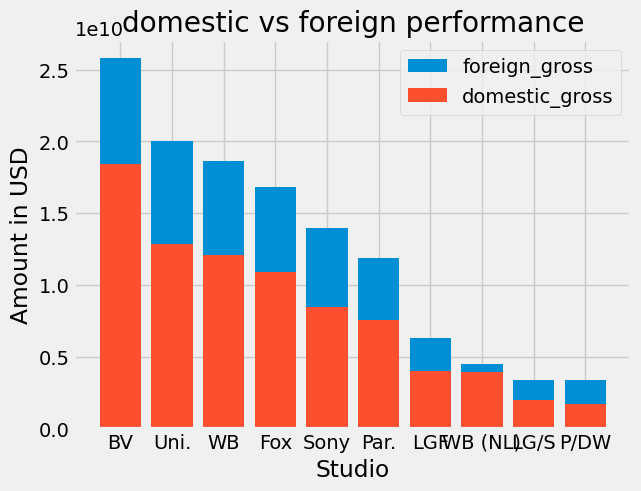

In [155]:
plt.style.use("fivethirtyeight")


plt.bar(ranking_index,foreign_gross_ranking)
plt.bar(ranking_index, domestic_gross_ranking)
plt.title("domestic vs foreign performance")
plt.xlabel("Studio")
plt.ylabel("Amount in USD")
plt.legend(['foreign_gross', 'domestic_gross'])
plt.show();

## relatioship between domestic and international marketing of a movie

to answer this, we establish the correlation between `foreign_gross` and `domestic_gross` of the `bom.movie_gross.csv.gz` 

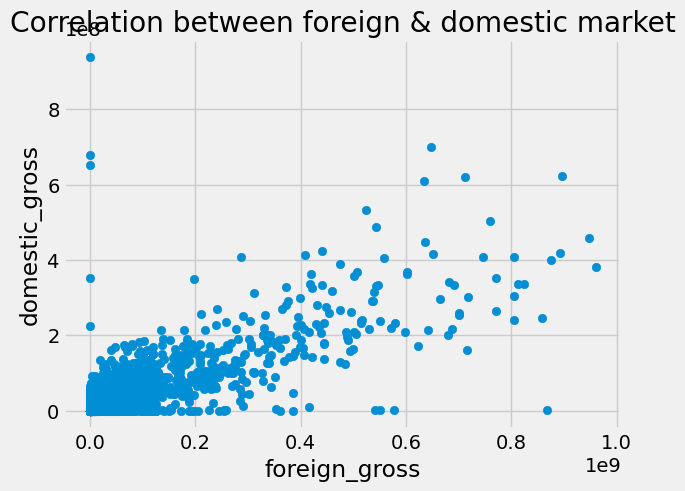

In [162]:
plt.scatter(movie_gross['foreign_gross'], movie_gross['domestic_gross'])
plt.title("Correlation between foreign & domestic market")
plt.xlabel("foreign_gross")
plt.ylabel("domestic_gross")
plt.show();

the scatter above shows that there is correlation between domestic  and international market forces

### END! thanks for following all along